# Решение задачи:

## Стратегия случайного поиска

Установка необходимых библиотек:

In [ ]:
!pip install gymnasium[atari] autorom[accept-rom-license] imageio > /dev/null 2>&1

Импорт необходимых библиотек и сосдание среды **MsPacman**:

In [ ]:
import gymnasium as gym
import ale_py
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio
from IPython.display import HTML
import base64

# Фикс для np.bool8 (на случай проблем с совместимостью)
np.bool8 = np.bool_

# Регистрация Atari-сред в Gymnasium
gym.register_envs(ale_py)

# Создание среды
env = gym.make("ALE/MsPacman-v5", render_mode="rgb_array")

Функция `preprocess_state` преобразует входное **RGB**-изображение состояния в одномерный нормализованный вектор размером **32x32**, конвертируя его в оттенки серого, уменьшая размер и нормализуя значения пикселей к диапазону [0, 1]:

In [ ]:
def preprocess_state(state):
    # Преобразуем в оттенки серого
    state = cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)
    # Уменьшаем размер до 32x32 (вместо 42x42)
    state = cv2.resize(state, (32, 32), interpolation=cv2.INTER_NEAREST)
    # Нормализуем значения пикселей [0, 1]
    state = state / 255.0
    # Преобразуем в одномерный вектор
    state = state.flatten()
    return state

Определяем размеры пространства состояний и действий:

In [ ]:
n_state = 32 * 32  # Размер вектора после предобработки
n_action = env.action_space.n  # Количество действий в MsPacman-v5

Функция `run_episode` выполняет один эпизод игры в среде `env`, используя веса `weight` для выбора действий, накапливая общее вознаграждение за максимум `max_steps` шагов. Она предобрабатывает состояния, выбирает действия через матричное умножение и завершает эпизод при достижении `max_steps` или сигналов `done`/`truncated`, возвращая суммарное вознаграждение:

In [ ]:
def run_episode(env, weight, max_steps=200):
    state = env.reset()[0]  # Получаем начальное состояние
    state = preprocess_state(state)  # Предобработка состояния
    total_reward = 0
    step = 0
    while step < max_steps:
        state = torch.from_numpy(state).float()
        action = torch.argmax(torch.matmul(state, weight))  # Выбор действия
        next_state, reward, done, truncated, _ = env.step(action.item())
        next_state = preprocess_state(next_state)  # Предобработка следующего состояния
        total_reward += reward
        state = next_state
        step += 1
        if done or truncated:
            break
    return total_reward

Инициализация параметров для стратегии случайного поиска:

In [ ]:
n_episode = 1000
best_total_reward_rs = 0
best_weight_rs = None
total_rewards_rs = []

Далее реализуем алгоритм случайного поиска (Random Search), генерируя случайные веса для каждого из `n_episode` эпизодов, оценивая их с помощью функции `run_episode`, и сохраняет лучшие веса и вознаграждение, а также вычислим среднее вознаграждение по всем эпизодам. Он выводит вознаграждение для каждого эпизода и итоговое среднее вознаграждение:

In [ ]:
for episode in range(n_episode):
    weight = torch.rand(n_state, n_action)  # Случайные веса
    total_reward = run_episode(env, weight, max_steps=200)
    print(f'Random Search - Эпизод {episode + 1}: {total_reward}')
    if total_reward > best_total_reward_rs:
        best_total_reward_rs = total_reward
        best_weight_rs = weight
    total_rewards_rs.append(total_reward)

print(f'Random Search - Среднее полное вознаграждение в {n_episode} эпизодах: {sum(total_rewards_rs) / n_episode}')

Random Search - Эпизод 1: 70.0
Random Search - Эпизод 2: 180.0
Random Search - Эпизод 3: 30.0
Random Search - Эпизод 4: 70.0
Random Search - Эпизод 5: 90.0
Random Search - Эпизод 6: 90.0
Random Search - Эпизод 7: 210.0
Random Search - Эпизод 8: 70.0
Random Search - Эпизод 9: 90.0
Random Search - Эпизод 10: 90.0
Random Search - Эпизод 11: 60.0
Random Search - Эпизод 12: 60.0
Random Search - Эпизод 13: 210.0
Random Search - Эпизод 14: 60.0
Random Search - Эпизод 15: 60.0
Random Search - Эпизод 16: 170.0
Random Search - Эпизод 17: 90.0
Random Search - Эпизод 18: 230.0
Random Search - Эпизод 19: 60.0
Random Search - Эпизод 20: 70.0
Random Search - Эпизод 21: 210.0
Random Search - Эпизод 22: 90.0
Random Search - Эпизод 23: 140.0
Random Search - Эпизод 24: 210.0
Random Search - Эпизод 25: 90.0
Random Search - Эпизод 26: 60.0
Random Search - Эпизод 27: 200.0
Random Search - Эпизод 28: 60.0
Random Search - Эпизод 29: 60.0
Random Search - Эпизод 30: 240.0
Random Search - Эпизод 31: 70.0
Random 

Затем оцениваем производительность лучшей модели, найденной алгоритмом случайного поиска (Random Search), запуская `n_episode_eval=100` эпизодов с лучшими весами `best_weight_rs`, накапливая вознаграждения и вычисляя их среднее значение. Выведем вознаграждение для каждого оценочного эпизода и итоговое среднее вознаграждение по всем эпизодам:

In [ ]:
# Оценка лучшей модели
n_episode_eval = 100
total_rewards_eval_rs = []
for episode in range(n_episode_eval):
    total_reward = run_episode(env, best_weight_rs, max_steps=200)
    print(f'Random Search - Оценка, эпизод {episode + 1}: {total_reward}')
    total_rewards_eval_rs.append(total_reward)

print(f'Random Search - Среднее полное вознаграждение в {n_episode_eval} эпизодах: {sum(total_rewards_eval_rs) / n_episode_eval}')

Random Search - Оценка, эпизод 1: 440.0
Random Search - Оценка, эпизод 2: 440.0
Random Search - Оценка, эпизод 3: 440.0
Random Search - Оценка, эпизод 4: 440.0
Random Search - Оценка, эпизод 5: 440.0
Random Search - Оценка, эпизод 6: 440.0
Random Search - Оценка, эпизод 7: 440.0
Random Search - Оценка, эпизод 8: 440.0
Random Search - Оценка, эпизод 9: 440.0
Random Search - Оценка, эпизод 10: 440.0
Random Search - Оценка, эпизод 11: 440.0
Random Search - Оценка, эпизод 12: 440.0
Random Search - Оценка, эпизод 13: 440.0
Random Search - Оценка, эпизод 14: 440.0
Random Search - Оценка, эпизод 15: 440.0
Random Search - Оценка, эпизод 16: 440.0
Random Search - Оценка, эпизод 17: 440.0
Random Search - Оценка, эпизод 18: 440.0
Random Search - Оценка, эпизод 19: 440.0
Random Search - Оценка, эпизод 20: 440.0
Random Search - Оценка, эпизод 21: 440.0
Random Search - Оценка, эпизод 22: 440.0
Random Search - Оценка, эпизод 23: 440.0
Random Search - Оценка, эпизод 24: 440.0
Random Search - Оценка, э

Построение графика:

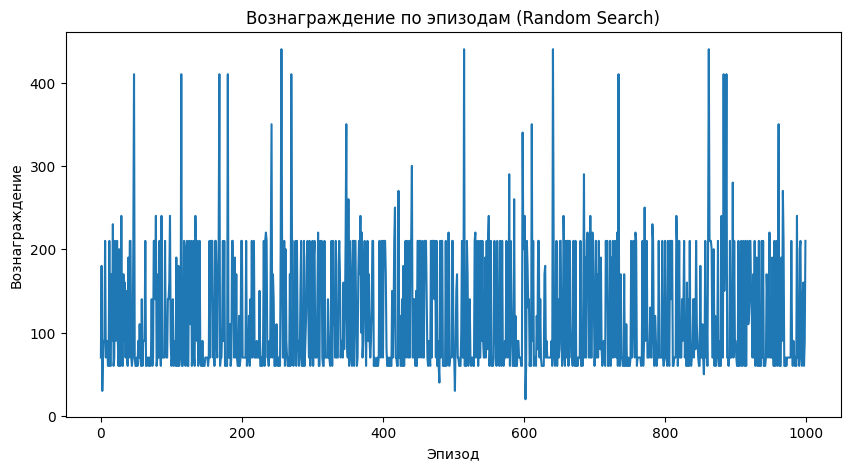

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(total_rewards_rs)
plt.xlabel('Эпизод')
plt.ylabel('Вознаграждение')
plt.title('Вознаграждение по эпизодам (Random Search)')
plt.show()

Оценим за сколько эпизодов алгоритм случайного поиска (Random Search) достигает порога вознаграждения `max_reward_threshold=200` в каждом из `n_training=100` запусков, используя до `n_episode=30` эпизодов с случайными весами, и вычисляет среднее число эпизодов, необходимых для достижения порога. Отобразим прогресс для каждого тренировочного запуска и итоговое математическое ожидание числа эпизодов или сообщение, если порог не был достигнут:

In [ ]:
# Оценка количества эпизодов для достижения порога
n_training = 100
n_episode = 30
n_episode_training_rs = []
max_reward_threshold = 200

for i in range(n_training):
    for episode in range(n_episode):
        weight = torch.rand(n_state, n_action)
        total_reward = run_episode(env, weight, max_steps=200)
        if total_reward >= max_reward_threshold:
            n_episode_training_rs.append(episode + 1)
            break
    print(f'Random Search - Завершено {i + 1}/{n_training} тренировочных запусков')

if n_episode_training_rs:
    print(f'Random Search - Математическое ожидание необходимого числа эпизодов: {sum(n_episode_training_rs) / len(n_episode_training_rs)}')
else:
    print('Random Search - Не удалось достичь порогового вознаграждения.')

Random Search - Завершено 1/100 тренировочных запусков
Random Search - Завершено 2/100 тренировочных запусков
Random Search - Завершено 3/100 тренировочных запусков
Random Search - Завершено 4/100 тренировочных запусков
Random Search - Завершено 5/100 тренировочных запусков
Random Search - Завершено 6/100 тренировочных запусков
Random Search - Завершено 7/100 тренировочных запусков
Random Search - Завершено 8/100 тренировочных запусков
Random Search - Завершено 9/100 тренировочных запусков
Random Search - Завершено 10/100 тренировочных запусков
Random Search - Завершено 11/100 тренировочных запусков
Random Search - Завершено 12/100 тренировочных запусков
Random Search - Завершено 13/100 тренировочных запусков
Random Search - Завершено 14/100 тренировочных запусков
Random Search - Завершено 15/100 тренировочных запусков
Random Search - Завершено 16/100 тренировочных запусков
Random Search - Завершено 17/100 тренировочных запусков
Random Search - Завершено 18/100 тренировочных запусков
R

# Алгоритм восхождения на вершину:

Инициализируем параметры для алгоритма восхождения на вершину:

In [ ]:
n_episode = 1000
best_total_reward_hc = 0
best_weight_hc = torch.rand(n_state, n_action)
total_rewards_hc = []
noise_scale = 0.01  # Начальный масштаб шума

Реализуем алгоритм восхождения на вершину (Hill Climbing), итеративно добавляя шум к лучшим весам `best_weight_hc` для `n_episode` эпизодов, обновляя их и уменьшая масштаб шума `noise_scale` при улучшении вознаграждения, или увеличивая при неудаче, сохраняя все вознаграждения для вычисления среднего. Код выводит вознаграждение и текущий `noise_scale` для каждого эпизода, а также итоговое среднее вознаграждение по всем эпизодам:

In [ ]:
for episode in range(n_episode):
    # Добавляем шум к лучшим весам
    weight = best_weight_hc + noise_scale * torch.rand(n_state, n_action)
    total_reward = run_episode(env, weight, max_steps=200)
    if total_reward >= best_total_reward_hc:
        best_total_reward_hc = total_reward
        best_weight_hc = weight
        noise_scale = max(noise_scale / 2, 1e-4)  # Уменьшаем шум при успехе
    else:
        noise_scale = min(noise_scale * 2, 2)  # Увеличиваем шум при неудаче
    total_rewards_hc.append(total_reward)
    print(f'Hill Climbing - Эпизод {episode + 1}: {total_reward} (noise_scale: {noise_scale})')

print(f'Hill Climbing - Среднее полное вознаграждение в {n_episode} эпизодах: {sum(total_rewards_hc) / n_episode}')

Hill Climbing - Эпизод 1: 120.0 (noise_scale: 0.005)
Hill Climbing - Эпизод 2: 140.0 (noise_scale: 0.0025)
Hill Climbing - Эпизод 3: 100.0 (noise_scale: 0.005)
Hill Climbing - Эпизод 4: 150.0 (noise_scale: 0.0025)
Hill Climbing - Эпизод 5: 80.0 (noise_scale: 0.005)
Hill Climbing - Эпизод 6: 140.0 (noise_scale: 0.01)
Hill Climbing - Эпизод 7: 150.0 (noise_scale: 0.005)
Hill Climbing - Эпизод 8: 140.0 (noise_scale: 0.01)
Hill Climbing - Эпизод 9: 140.0 (noise_scale: 0.02)
Hill Climbing - Эпизод 10: 140.0 (noise_scale: 0.04)
Hill Climbing - Эпизод 11: 90.0 (noise_scale: 0.08)
Hill Climbing - Эпизод 12: 80.0 (noise_scale: 0.16)
Hill Climbing - Эпизод 13: 60.0 (noise_scale: 0.32)
Hill Climbing - Эпизод 14: 230.0 (noise_scale: 0.16)
Hill Climbing - Эпизод 15: 120.0 (noise_scale: 0.32)
Hill Climbing - Эпизод 16: 230.0 (noise_scale: 0.16)
Hill Climbing - Эпизод 17: 190.0 (noise_scale: 0.32)
Hill Climbing - Эпизод 18: 210.0 (noise_scale: 0.64)
Hill Climbing - Эпизод 19: 60.0 (noise_scale: 1.28)

Выполним оценку модели по аналогии с прошлой реализацией:

In [ ]:
# Оценка лучшей модели
n_episode_eval = 100
total_rewards_eval_hc = []
for episode in range(n_episode_eval):
    total_reward = run_episode(env, best_weight_hc, max_steps=200)
    print(f'Hill Climbing - Оценка, эпизод {episode + 1}: {total_reward}')
    total_rewards_eval_hc.append(total_reward)

print(f'Hill Climbing - Среднее полное вознаграждение в {n_episode_eval} эпизодах: {sum(total_rewards_eval_hc) / n_episode_eval}')

Hill Climbing - Оценка, эпизод 1: 440.0
Hill Climbing - Оценка, эпизод 2: 440.0
Hill Climbing - Оценка, эпизод 3: 440.0
Hill Climbing - Оценка, эпизод 4: 440.0
Hill Climbing - Оценка, эпизод 5: 440.0
Hill Climbing - Оценка, эпизод 6: 440.0
Hill Climbing - Оценка, эпизод 7: 440.0
Hill Climbing - Оценка, эпизод 8: 440.0
Hill Climbing - Оценка, эпизод 9: 440.0
Hill Climbing - Оценка, эпизод 10: 440.0
Hill Climbing - Оценка, эпизод 11: 440.0
Hill Climbing - Оценка, эпизод 12: 440.0
Hill Climbing - Оценка, эпизод 13: 440.0
Hill Climbing - Оценка, эпизод 14: 440.0
Hill Climbing - Оценка, эпизод 15: 440.0
Hill Climbing - Оценка, эпизод 16: 440.0
Hill Climbing - Оценка, эпизод 17: 440.0
Hill Climbing - Оценка, эпизод 18: 440.0
Hill Climbing - Оценка, эпизод 19: 440.0
Hill Climbing - Оценка, эпизод 20: 440.0
Hill Climbing - Оценка, эпизод 21: 440.0
Hill Climbing - Оценка, эпизод 22: 440.0
Hill Climbing - Оценка, эпизод 23: 440.0
Hill Climbing - Оценка, эпизод 24: 440.0
Hill Climbing - Оценка, э

Построим график:

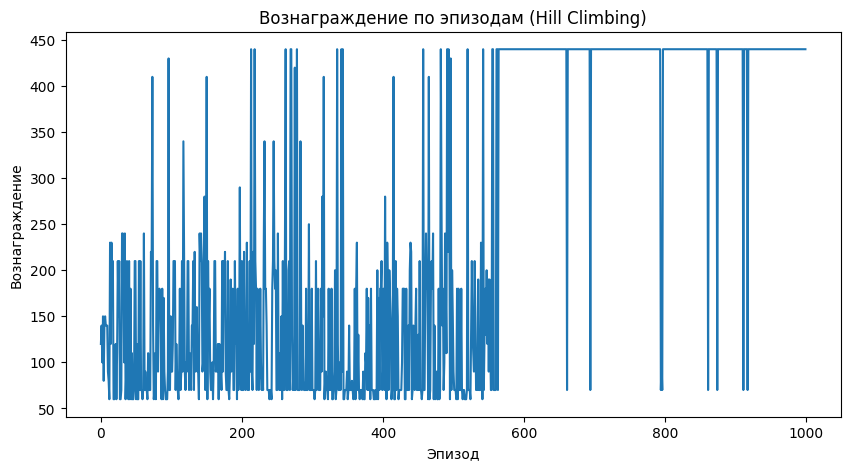

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(total_rewards_hc)
plt.xlabel('Эпизод')
plt.ylabel('Вознаграждение')
plt.title('Вознаграждение по эпизодам (Hill Climbing)')
plt.show()

Следующий код оценивает, за сколько эпизодов алгоритм восхождения на вершину (Hill Climbing) достигает порога вознаграждения `max_reward_threshold=200` в каждом из `n_training=100` запусков, используя до `n_episode=30` эпизодов с итеративным добавлением шума к случайным начальным весам и адаптацией масштаба шума `noise_scale`, после чего вычисляет среднее число эпизодов, необходимых для достижения порога. Выводится прогресс для каждого тренировочного запуска и итоговое математическое ожидание числа эпизодов или сообщение, если порог не был достигнут:

In [ ]:
n_training = 100
n_episode = 30
n_episode_training_hc = []
max_reward_threshold = 200

for i in range(n_training):
    best_total_reward = 0
    best_weight = torch.rand(n_state, n_action)  # Начальные случайные веса
    noise_scale = 0.01
    for episode in range(n_episode):
        weight = best_weight + noise_scale * torch.rand(n_state, n_action)
        total_reward = run_episode(env, weight, max_steps=200)
        if total_reward >= best_total_reward:
            best_total_reward = total_reward
            best_weight = weight
            noise_scale = max(noise_scale / 2, 1e-4)
        else:
            noise_scale = min(noise_scale * 2, 2)
        if total_reward >= max_reward_threshold:
            n_episode_training_hc.append(episode + 1)
            break
    print(f'Hill Climbing - Завершено {i + 1}/{n_training} тренировочных запусков')

if n_episode_training_hc:
    print(f'Hill Climbing - Математическое ожидание необходимого числа эпизодов: {sum(n_episode_training_hc) / len(n_episode_training_hc)}')
else:
    print('Hill Climbing - Не удалось достичь порогового вознаграждения.')

Hill Climbing - Завершено 1/100 тренировочных запусков
Hill Climbing - Завершено 2/100 тренировочных запусков
Hill Climbing - Завершено 3/100 тренировочных запусков
Hill Climbing - Завершено 4/100 тренировочных запусков
Hill Climbing - Завершено 5/100 тренировочных запусков
Hill Climbing - Завершено 6/100 тренировочных запусков
Hill Climbing - Завершено 7/100 тренировочных запусков
Hill Climbing - Завершено 8/100 тренировочных запусков
Hill Climbing - Завершено 9/100 тренировочных запусков
Hill Climbing - Завершено 10/100 тренировочных запусков
Hill Climbing - Завершено 11/100 тренировочных запусков
Hill Climbing - Завершено 12/100 тренировочных запусков
Hill Climbing - Завершено 13/100 тренировочных запусков
Hill Climbing - Завершено 14/100 тренировочных запусков
Hill Climbing - Завершено 15/100 тренировочных запусков
Hill Climbing - Завершено 16/100 тренировочных запусков
Hill Climbing - Завершено 17/100 тренировочных запусков
Hill Climbing - Завершено 18/100 тренировочных запусков
H

Функция `run_episode_with_video` выполняет один эпизод игры в среде `env` с использованием весов `weight`, записывая RGB-кадры для видео и накапливая вознаграждение за максимум `max_steps=200` шагов, завершая эпизод при `done` или `truncated`, и возвращает суммарное вознаграждение и список кадров:

In [ ]:
# Функция для запуска эпизода с записью видео
def run_episode_with_video(env, weight, max_steps=200):
    frames = []  # Список для хранения кадров видео
    state = env.reset()[0]  # Получаем начальное состояние
    total_reward = 0
    step = 0
    while step < max_steps:
        # Добавляем текущий кадр в видео (RGB-изображение без предобработки)
        frames.append(env.render())  # env.render() возвращает RGB-кадр

        state = preprocess_state(state)  # Предобработка для принятия решения
        state = torch.from_numpy(state).float()
        action = torch.argmax(torch.matmul(state, weight))  # Выбор действия
        next_state, reward, done, truncated, _ = env.step(action.item())
        total_reward += reward
        state = next_state
        step += 1
        if done or truncated:
            # Добавляем финальный кадр
            frames.append(env.render())
            break
    return total_reward, frames

Далее, код выбирает лучшие веса (`best_weight`) из **Hill Climbing** или **Random Search**, основываясь на наибольшем вознаграждении, запускает один эпизод с записью кадров с помощью `run_episode_with_video`, сохраняет кадры как зацикленный *GIF-файл* с именем, включающим полученное вознаграждение, и выводит сообщение о сохранении видео:

In [ ]:
# Выбор лучших весов (Hill Climbing, если лучше, иначе Random Search)
best_weight = best_weight_hc if best_total_reward_hc > best_total_reward_rs else best_weight_rs

# Запускаем эпизод с записью кадров
total_reward, frames = run_episode_with_video(env, best_weight, max_steps=200)

# Сохраняем видео как GIF
video_filename = f"ms_pacman_best_episode_reward_{total_reward}.gif"
imageio.mimsave(video_filename, frames, fps=30, loop=0)  # FPS=30 для плавной анимации

print(f"Видео сохранено как {video_filename} с вознаграждением: {total_reward}")

Видео сохранено как ms_pacman_best_episode_reward_440.0.gif с вознаграждением: 440.0


Отображаем гифку:


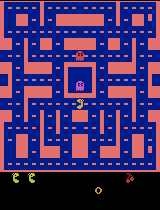

In [ ]:
def show_video_in_colab(video_path):
    gif = open(video_path, 'rb').read()
    data_url = "data:image/gif;base64," + base64.b64encode(gif).decode()
    return HTML(f"""
    <img src="{data_url}" alt="Видео эпизода MsPacman" style="width: 600px; height: auto;">
    """)

show_video_in_colab(video_filename)